<a href="https://colab.research.google.com/github/EyberRosero/Analitica-De-Datos/blob/master/Tarea1(Regresores)_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#CARGANDO MODULOS 
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as msa
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import mode
from datetime import date


##Cargar Base de datos con link en código






In [30]:
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23,174,174,187,208,208
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22,25,25,34,34
264,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,8,8,8,11


Text(0, 0.5, 'Latitud')

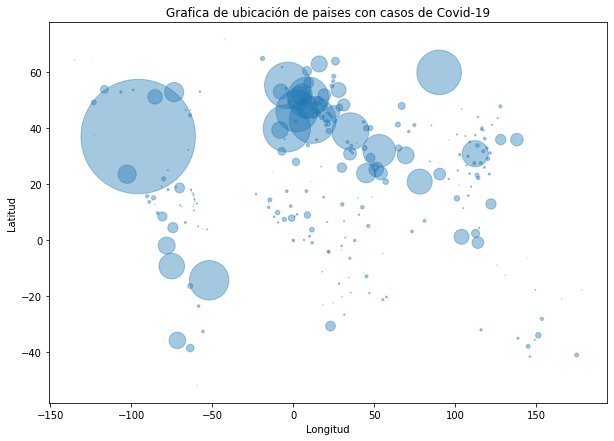

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Xd.plot(kind="scatter", x="Long", y="Lat",alpha=0.4,s=Xd["5/9/20"]/100, figsize=(10,7))
#plt.scatter(Xd['Long'],Xd['Lat'],alpha=0.6)
plt.title(u'Grafica de ubicación de paises con casos de Covid-19')
plt.xlabel('Longitud') 
plt.ylabel(u'Latitud') 

##Funcion para hacer ventaneo 


In [0]:
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

Se extrae las datos correspondientes a "Colombia" y se grafican 

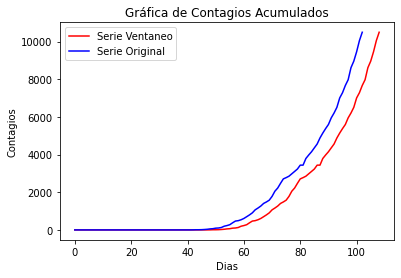

Serie: (109,)
X: (103, 5)
y: (103, 1)
Xd: (103, 5)
Xd: (103, 1)


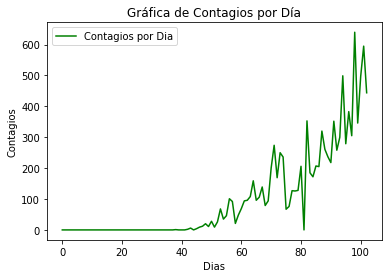

In [33]:

ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
w = 5
X,y = covid_win(serie,w=w)
X_d,y_d = covid_win(serie_d,w=w)

plt.plot(serie,'r',label='Serie Ventaneo')
plt.plot(y,'b',label='Serie Original')
plt.title(u'Gráfica de Contagios Acumulados')
plt.xlabel('Dias') 
plt.ylabel(u'Contagios') 
plt.legend()

plt.show()
plt.plot(y_d,'g',label='Contagios por Dia')
plt.title(u'Gráfica de Contagios por Día')
plt.xlabel('Dias') 
plt.ylabel(u'Contagios') 
plt.legend()

print('Serie:', serie.shape)
print('X:', X.shape)
print('y:', y.shape)
print('Xd:', X_d.shape)
print('Xd:', y_d.shape)

Se puede observar que la curva de contagios acumulados es una curva que puede ser muy facil de "predecir" con los regresores que se usaran adelante, el corrimiento de la grafica de contagios acumulados de color "rojo" se debe al ventaneo que se llevo acabo; la grafica verde corresponde a los contagios por dia, en el transcurso de este cuaderno, podemos ver que curva puede ser mas dificil de predecir, al final miraremos los resultados.

#Entrenamiento del regresor para la base de datos

##Analisis exploratorio - visualizacion en 2D PCA 


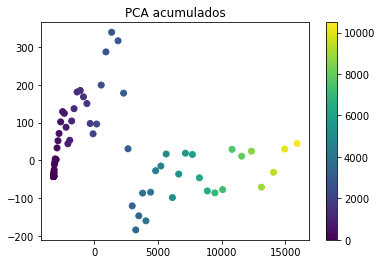

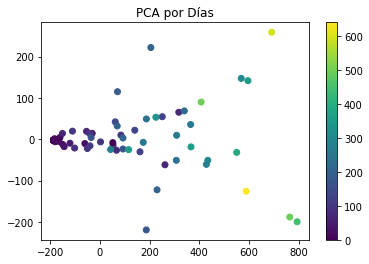

In [34]:
from sklearn.decomposition import PCA

redP = PCA() #acumulado
redP_d = PCA() #por dia

zP = redP.fit_transform(X)
zP_d = redP_d.fit_transform(X_d)

plt.scatter(zP[:,0],zP[:,1],c=y)
plt.title('PCA acumulados')
plt.colorbar()
plt.show()


plt.scatter(zP_d[:,0],zP_d[:,1],c=y_d)
plt.title('PCA por Días')
plt.colorbar()
plt.show()


##Analisis exploratorio - visualizacion en 2D TSNE

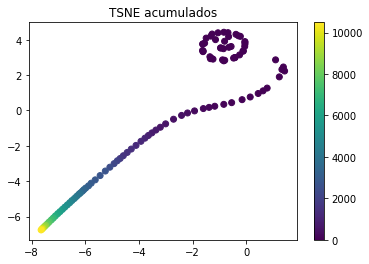

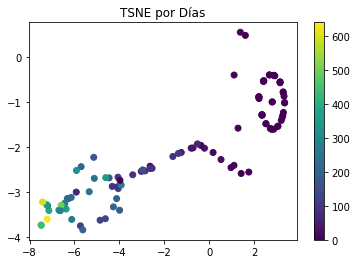

In [35]:
from sklearn.manifold import TSNE

redT = TSNE()
redT_d = TSNE()

zT = redT.fit_transform(X)
zT_d = redT_d.fit_transform(X_d)

plt.scatter(zT[:,0],zT[:,1],c=y)
plt.title('TSNE acumulados')
plt.colorbar()
plt.show()


plt.scatter(zT_d[:,0],zT_d[:,1],c=y_d)
plt.title('TSNE por Días')
plt.colorbar()
plt.show()

#Se declara una Clase Custm TSNE con mapeo de puntos nuevos por vecinos mas cercanos y se observa su comportamiento en datos de entremamiento y test del Covid19


In [0]:
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsRegressor
class tsne_map(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, n_components = 2,perplexity=10, n_neighbors = 10): #constructor clase con hyperparámetros
        self.n_components = n_components
        self.perplexity = perplexity
        self.n_neighbors = n_neighbors
        return None

    def fit(self,X,*_): #entrenamiento, primero se hace tsne y luego se entrena el regresor knn para llevar del espacio X as Z
        red = TSNE(n_components = self.n_components,perplexity=self.perplexity)
        z = red.fit_transform(X)

        self.neigh = KNeighborsRegressor(n_neighbors=self.n_neighbors) 
        self.neigh.fit(X, z) #entrenamiento knn, se guarda en la clase
        return self
    def transform(self,X,*_):
       return self.neigh.predict(X) #evaluar en puntos nuevos-> transform o predict

    def fit_transform(self,X,*_): #entrenar y evaluar, solo para caso xtrain y ztrain
        self.fit(X)
        red = TSNE(n_components = self.n_components,perplexity=self.perplexity)
        return self.transform(X)#red.fit_transform(X)

(72, 5)
(31, 5)


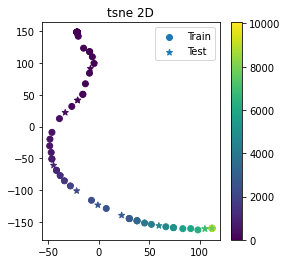

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)

#ejemplo de uso clase custom tsne
red = tsne_map()
z_train = red.fit_transform(X_train)
z_test = red.transform(X_test) #mapear test

plt.figure(figsize=(4,4))
plt.scatter(z_train[:,0],z_train[:,1],c=y_train,label='Train')
plt.scatter(z_test[:,0],z_test[:,1],c=y_test,s=40,marker='*',label='Test')
plt.colorbar()
plt.legend()
plt.title('tsne 2D')
plt.show()


##A continuacion se definiran los regresores que se van a usar 

La intencion es ajustar los hyperramaters de algunos regresores lineales, en este caso se van a usar los siguientes: 

* LinearRegression (mínimos cuadrados o máxima verisimilitud)
* Ridge (Regresión bayesiana al ruido isotrópico)
* Lasso
* ElasticNet
* KernelRidge 




Por Niter de outter loop tengo valores de los hyperparameters, que gamma no varie para que el modelo sea estable y confiable 


In [0]:

        
steps = [
     [('scaler', StandardScaler()), #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
    ('reg',  KernelRidge(kernel = 'rbf'))], #clasificador 

    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', LinearRegression(fit_intercept = 'False'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', LinearRegression())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', Ridge())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', Lasso())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', ElasticNet())],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'rbf'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'sigmoid'))],
    
    [('scaler', StandardScaler()),
    ('rep', PCA()),
    ('reg', KernelRidge(kernel = 'laplacian'))],
    
    
    #usando tsne custom
    [('scaler', StandardScaler()),
    ('rep', tsne_map(n_components = 2,  
                     perplexity = 30, 
                     n_neighbors = 3)),
    ('reg', KernelRidge(kernel = 'sigmoid'))]
    
]    


#parametros a buscar por busqueda por grilla
parameters =[
    {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
      'reg__alpha':[1e-3,1e-2,1e-1,1,10]
    },
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,10)     
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5)
    }, 
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__l1_ratio': np.linspace(0.1,1,5)
    }, 
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    },
    
    {'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]),
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    }, 
    
    #parametros de TSNE custom
    {#'rep__n_components': np.array([0.1, 0.2, 0.5, 0.7, 1]), 
     'reg__alpha': np.linspace(0.1,1,5),
     'reg__gamma': np.linspace(0.1,1,5),
    }
]


label_model = ['NorSC-KRRBF','Linear', 'Linear fit', 'Ridge', 'Lasso', 'Elastic', 
               'Kernel rbf', 'Kernel sigmoid', 'Kernel laplacian','Kernel Sigmoid Custom']

##Se hace la validacion cruzada anidad sobre los datos de CONTAGIOS ACUMULADOS 

In [39]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion 
Xdata, ydata = X,y 
#############################
for j in range(Niter): #outter loop
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=5,scoring='neg_mean_absolute_error',n_jobs=4) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          msev[j,r] = msa(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('msa:',msev[j,r])
          
      best_estimators[j] = list_est #guardar mejores modelos 
      best_hyperpar[j] = list_hyper #mejores hyperparametros
          
          
      savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
      dump(savedata,'covid19_1.joblib')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s


it 1/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 48.271270971503036
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 1/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 92.43811814466443
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 1/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 92.43811814466443
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 92.62944874019078
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 92.44901171857182
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 92.44901171857182
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 72.52139969841306
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 576 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 64.88566854388114
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 46.51328597434967
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   14.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 10/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.55}
msa: 11161.69475453142
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 2/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 41.91775692352343
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 2/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 91.89003894699614
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 2/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 91.89003894699614
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 2/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 92.04343289157787
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 2/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 91.8987002336654
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 91.8987002336654
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 523 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.325, 'rep__n_components': 0.1}
msa: 52.398566595042574
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


it 2/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 74.28914925131564
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 42.80082664064163
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 2/10-Modelo 10/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1}
msa: 8590.463970013043
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 63.77769646425992
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 3/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 106.94443219088008
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 3/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 106.94443219088008
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 3/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 106.71911155048758
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 3/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 106.93088684583202
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 3/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 106.93088684583202
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 154.37560408738398
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 3/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 95.04643864354736
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished


it 3/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 96.57179204994917
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 3/10-Modelo 10/10
best hyper {'reg__alpha': 0.775, 'reg__gamma': 0.55}
msa: 5179.446658634642
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 4/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 59.779938917314155
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 4/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 95.9481543285753
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  19 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 4/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 95.9481543285753
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 4/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 96.06494870251909
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 95.954645580993
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished


it 4/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 95.954645580993
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished


it 4/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 81.87006200153581
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 4/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 78.76149818710687
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 4/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 45.03962361949877
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 10/10
best hyper {'reg__alpha': 0.775, 'reg__gamma': 0.1}
msa: 3405.509537441317
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 58.618048041014724
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 5/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 89.38877264381625
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 5/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 89.38877264381625
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 5/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 89.48353711391007
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s


it 5/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 89.39465042800632
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 89.39465042800632
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 85.66482701375648
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 5/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 74.68905048160606
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 75.68527615347048
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.6s finished


it 5/10-Modelo 10/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1}
msa: 13964.820975547229
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 6/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 55.04292428486928
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 6/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 92.58092344367138
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 6/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 92.58092344367138
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 6/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 92.65227361090662
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 6/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 92.58506959721255
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 6/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 92.58506959721255
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished


it 6/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 80.86908202705438
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 6/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 86.10049016511942
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 45.25256722655793
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 6/10-Modelo 10/10
best hyper {'reg__alpha': 1.0, 'reg__gamma': 0.325}
msa: 865.69288555841
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s


it 7/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 54.67240867203914
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 7/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 87.14531514702875
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 7/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 87.14531514702875
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 7/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 87.15246935110106
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 87.1457473268499
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 87.1457473268499
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 134.36563193275717
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 82.33314983873679
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 104.61069251524133
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


it 7/10-Modelo 10/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 1.0}
msa: 2524.737549503612
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.01}
msa: 53.35108671484951
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 8/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 99.28707882191308
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 99.28707882191308
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.2s


it 8/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 99.15707080685398
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 113 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 99.27940435622388
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 99.27940435622388
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 94.44529954790515
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 8/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 89.57611748987557
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 520 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished


it 8/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 47.3105139077465
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 8/10-Modelo 10/10
best hyper {'reg__alpha': 0.55, 'reg__gamma': 0.55}
msa: 1572.9204070932242
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 42.107004690204356
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 9/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 90.23977588641584
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s


it 9/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 90.23977588641584
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.1s


it 9/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 90.45905110088563
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 9/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 90.25335529264022
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 90.25335529264022
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 70.83708430166531
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 9/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 73.04886536555853
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 62.98808890237738
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.2s finished


it 9/10-Modelo 10/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.325}
msa: 2250.6484141377914
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  12 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 1/10
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.1}
msa: 53.92420849940742
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 10/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 87.21636191939635
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s


it 10/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 87.21636191939635
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 10/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 87.38294849828485
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 87.22629510362422
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 87.22629510362422
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.325, 'rep__n_components': 0.1}
msa: 123.78227661384713
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 10/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 75.38397837806248
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 97.54098282799761
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.9s finished


it 10/10-Modelo 10/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.55}
msa: 2156.482465524464


##INFORMACIÓN DE RESULTADOS DE LOS MODELOS

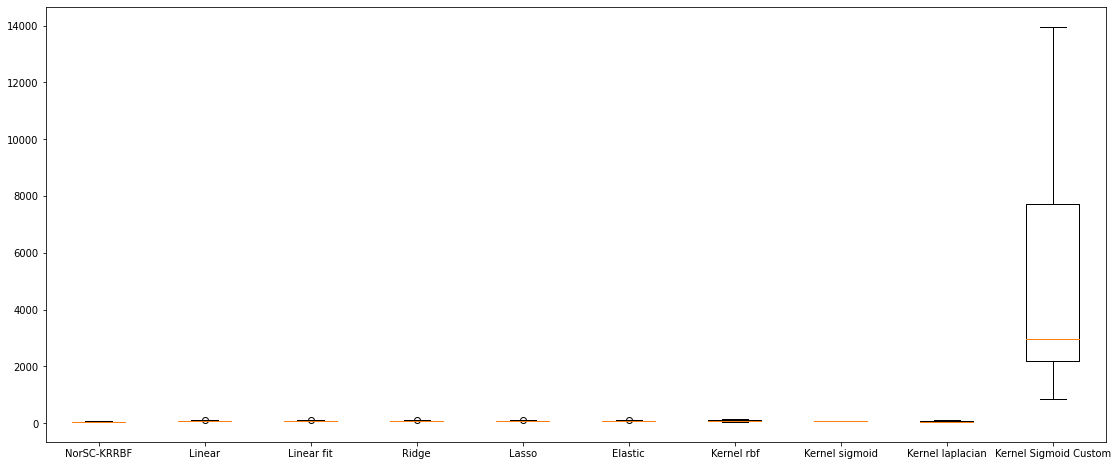

In [40]:
plt.figure(figsize=(19,8))
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()

##MEJORES HIPERPARAMETROS DE CADA MODELO

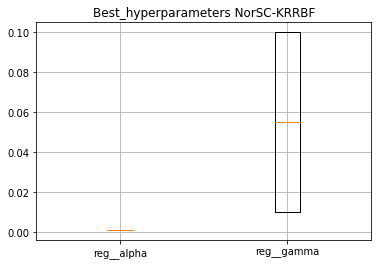

Modes=  [0.001 0.01 ]
Predicción contagiados covid19  2020-05-11 = [11284.31143783]


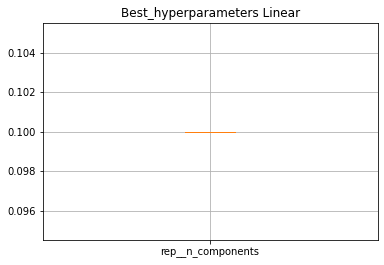

Modes=  [0.1]
Predicción contagiados covid19  2020-05-11 = [11670.57466905]


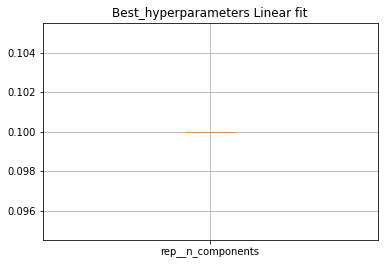

Modes=  [0.1]
Predicción contagiados covid19  2020-05-11 = [11670.57466905]


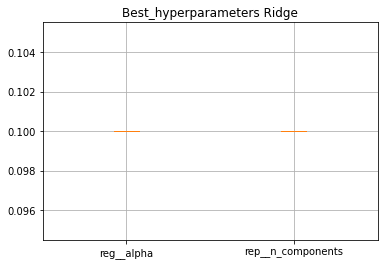

Modes=  [0.1 0.1]
Predicción contagiados covid19  2020-05-11 = [11668.65708212]


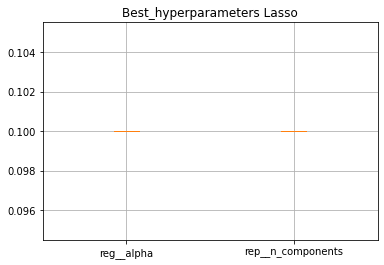

Modes=  [0.1 0.1]
Predicción contagiados covid19  2020-05-11 = 11670.412893627217


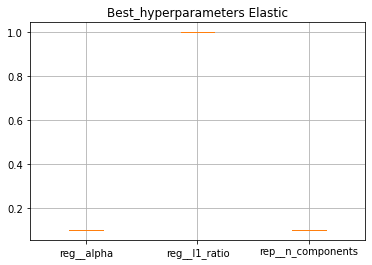

Modes=  [0.1 1.  0.1]
Predicción contagiados covid19  2020-05-11 = 10163.808400371048


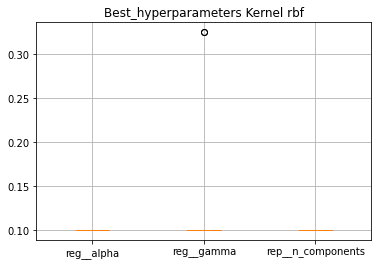

Modes=  [0.1 0.1 0.1]
Predicción contagiados covid19  2020-05-11 = [8651.42731064]


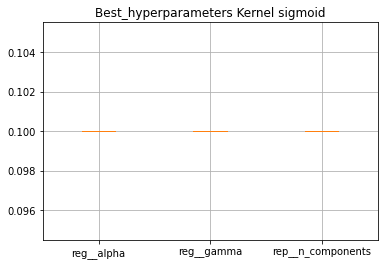

Modes=  [0.1 0.1 0.1]
Predicción contagiados covid19  2020-05-11 = [12191.43830844]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


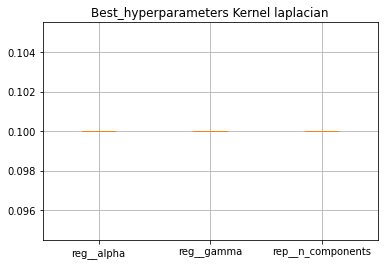

Modes=  [0.1 0.1 0.1]
Predicción contagiados covid19  2020-05-11 = [8923.9594782]


In [41]:
from scipy.stats import mode
from datetime import date

model_f = np.zeros((10, 1),dtype=object)

for r in range(9):
  nh = len(best_hyperpar[0][r])
  hyperpar_r = np.zeros((Niter,nh)) 
  for i in range(Niter):
    for j in range(nh):
      hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])

# revisar numero entero para realizar casting
  aa = list(best_hyperpar[0][r].keys())
  c = -1
  for i in range(len(aa)):
      if aa[i].find('n_neighbors') > -1:
        c = i

  plt.boxplot(hyperpar_r)
  plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
  plt.title('Best_hyperparameters '+label_model[r])
  plt.grid()
  plt.show()

  mode_hyper = mode(hyperpar_r,axis=0)[0][0]
  print("Modes= ", mode_hyper)

  model_f[r,0] = Pipeline(steps[r])
  paramsf = parameters[r]
  hyperl = list(parameters[r].keys())
  nh = len(hyperl)
  for j in range(nh):
    if j == c: 
      paramsf[hyperl[j]] = int(mode_hyper[j])
    else:
      paramsf[hyperl[j]] = mode_hyper[j] 

  model_f[r,0].set_params(**paramsf)
  model_f[r,0].fit(Xdata,ydata) #entrenar con todos los datos porque no tenemos suficientes > 10000 entrenar xtrain de lo contrario con todo el dataset

  print('Predicción contagiados covid19 ',date.today(),'=',model_f[r,0].predict(serie[len(serie)-w:].reshape(1,-1))[0])



##RESULTADO DE PREDICCION DE CADA MODELO

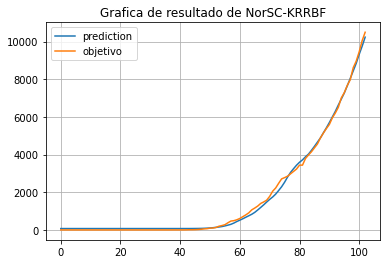

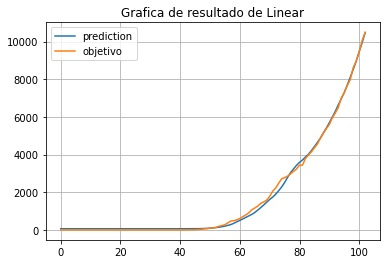

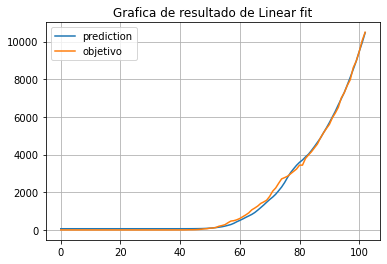

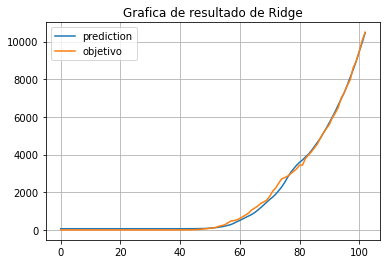

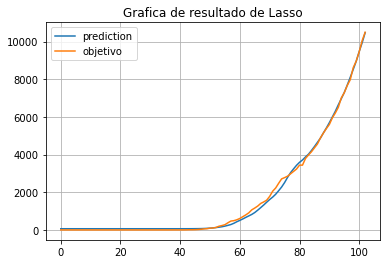

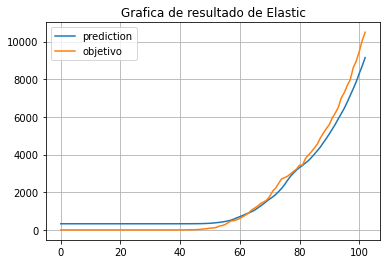

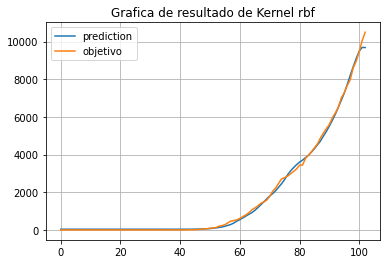

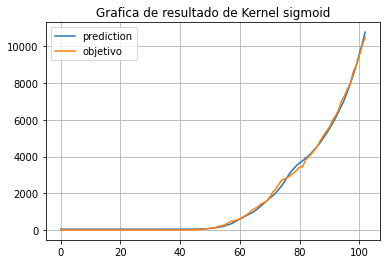

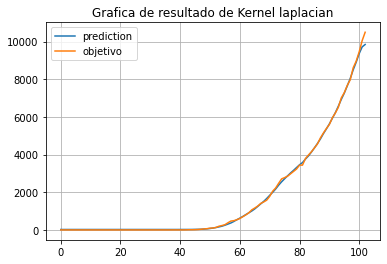

In [43]:

#curva predicción sobre modelo  final
for r in range(9):
  plt.plot(model_f[r,0].predict(Xdata),label='prediction')
  plt.plot(ydata,label='objetivo')
  plt.title('Grafica de resultado de '+label_model[r])
  plt.grid()
  plt.legend()
  plt.show()


### A continuacion se hará la validacion cruzada anidada para los datos de CONTAGIOS POR DIA 

In [24]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion 
Xdata, ydata = X_d,y_d 
#############################
for j in range(Niter): #outter loop
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=5,scoring='neg_mean_absolute_error',n_jobs=4) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          msev[j,r] = msa(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('msa:',msev[j,r])
          
      best_estimators[j] = list_est #guardar mejores modelos 
      best_hyperpar[j] = list_hyper #mejores hyperparametros
          
          
      savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
      dump(savedata,'covid19_1.joblib')

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 37.01678373619647
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 1/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 33.56460222245354
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 33.56460222245354
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 33.57592065259784
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 33.58014803942939
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 33.58014803942939
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished


it 1/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 40.638107821946036
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 520 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 1/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 1.0, 'rep__n_components': 0.1}
msa: 57.18636665226913
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 1/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 43.24521336158308
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.8s finished


it 1/10-Modelo 10/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 1.0}
msa: 138.53454945939936
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  25 | elapsed:    0.1s remaining:    0.1s


it 2/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 35.116670452759976
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 2/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 36.27964266405018
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 2/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 36.27964266405018
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 2/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 36.276633051279106
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 tasks      | elapsed:    0.2s


it 2/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 36.2766447475819
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 578 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 36.2766447475819
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 36.918895693282195
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 2/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 36.869720005121
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 2/10-Modelo 9/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 36.47976970439137
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   28.9s finished


it 2/10-Modelo 10/10
best hyper {'reg__alpha': 1.0, 'reg__gamma': 0.1}
msa: 85.01505502687407
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 32.05477382976014
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 3/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 32.733271452552366
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 3/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 32.733271452552366
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 3/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 32.73903664778462
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s


it 3/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 32.739814983071504
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 464 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 32.739814983071504
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 527 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 3/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 36.275064041690754
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 32.065591858017726
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 3/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 37.830097044417556
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 3/10-Modelo 10/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.775}
msa: 86.52677745898725
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 4/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 43.719619669182244
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 4/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 42.23170652282175
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 4/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 42.23170652282175
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 42.23499026975657
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 42.23584743396564
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 4/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 42.23584743396564
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished


it 4/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 42.18920101758449
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 4/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 38.91789752792409
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 4/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 44.9464840480813
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.1s


it 4/10-Modelo 10/10
best hyper {'reg__alpha': 0.55, 'reg__gamma': 0.325}
msa: 134.6284205805147
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s


it 5/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 42.158207428020695
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 5/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 36.781230626481126
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 5/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 36.781230626481126
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 5/10-Modelo 4/10
best hyper {'reg__alpha': 1.0, 'rep__n_components': 0.1}
msa: 36.475086922008416
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    0.1s


it 5/10-Modelo 5/10
best hyper {'reg__alpha': 1.0, 'rep__n_components': 0.1}
msa: 36.422119133057905
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 520 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 6/10
best hyper {'reg__alpha': 0.325, 'reg__l1_ratio': 0.775, 'rep__n_components': 0.1}
msa: 35.7465666448806
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 5/10-Modelo 7/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 42.746786766093095
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 542 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 5/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 48.45464673801781
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 5/10-Modelo 9/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 38.57995828123672
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 5/10-Modelo 10/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.775}
msa: 86.1946023371355
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 41.28706483482282
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 6/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 38.67678523394778
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s


it 6/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 38.67678523394778
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 6/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 38.68105457609976
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s


it 6/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 38.681142371060844
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 38.681142371060844
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 37.18839299511227
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 6/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 37.00311774588361
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 9/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 37.275461550864016
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 6/10-Modelo 10/10
best hyper {'reg__alpha': 1.0, 'reg__gamma': 0.55}
msa: 71.10563963211355
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 7/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 41.11853688501827
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 7/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 36.11757443386926
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 7/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 36.11757443386926
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 7/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 36.12240390818004
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    0.1s


it 7/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 36.12330578169721
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 36.12330578169721
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 7/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 34.15681647235843
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 7/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 36.58994659348428
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 7/10-Modelo 9/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 37.603426533715286
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.3s finished


it 7/10-Modelo 10/10
best hyper {'reg__alpha': 0.55, 'reg__gamma': 0.775}
msa: 123.2848460883748
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 8/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 41.71223441088941
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 8/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 38.55170003494211
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s


it 8/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 38.55170003494211
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 8/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 38.56024608807057
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 8/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 38.56260158395924
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 38.56260158395924
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished


it 8/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.325, 'rep__n_components': 0.1}
msa: 40.32121256013576
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 536 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 36.28525815977535
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 9/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 40.62157416117836
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   34.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 8/10-Modelo 10/10
best hyper {'reg__alpha': 0.55, 'reg__gamma': 0.325}
msa: 134.5665427780933
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 9/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 27.5276924309267
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 9/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 28.97862531096913
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s


it 9/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 28.97862531096913
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 243 out of 250 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 9/10-Modelo 4/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 28.978791954725956
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s


it 9/10-Modelo 5/10
best hyper {'reg__alpha': 0.1, 'rep__n_components': 0.1}
msa: 28.978799594863744
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 1.0, 'rep__n_components': 0.1}
msa: 28.978799594863744
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 7/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 29.021401392393688
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 26.451734030791847
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 561 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 9/10-Modelo 9/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 29.79987875866698
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.0s


it 9/10-Modelo 10/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1}
msa: 61.16309503118683
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 1/10
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 34.42068873938555
Fitting 5 folds for each of 5 candidates, totalling 25 fits
it 10/10-Modelo 2/10
best hyper {'rep__n_components': 0.1}
msa: 33.5297299443773
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s


it 10/10-Modelo 3/10
best hyper {'rep__n_components': 0.1}
msa: 33.5297299443773
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 10/10-Modelo 4/10
best hyper {'reg__alpha': 1.0, 'rep__n_components': 0.1}
msa: 33.42085699357045
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    0.1s


it 10/10-Modelo 5/10
best hyper {'reg__alpha': 1.0, 'rep__n_components': 0.1}
msa: 33.419041777470525
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 488 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 6/10
best hyper {'reg__alpha': 0.1, 'reg__l1_ratio': 0.1, 'rep__n_components': 0.1}
msa: 33.28108644887913
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


it 10/10-Modelo 7/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 31.996558814506596
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 552 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    0.1s


it 10/10-Modelo 8/10
best hyper {'reg__alpha': 0.1, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 34.796807828941645
Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=4)]: Done 558 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 618 out of 625 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 625 out of 625 | elapsed:    1.8s finished


it 10/10-Modelo 9/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.1, 'rep__n_components': 0.1}
msa: 30.67800126438448
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   29.3s finished


it 10/10-Modelo 10/10
best hyper {'reg__alpha': 0.325, 'reg__gamma': 0.775}
msa: 119.39273668076798


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


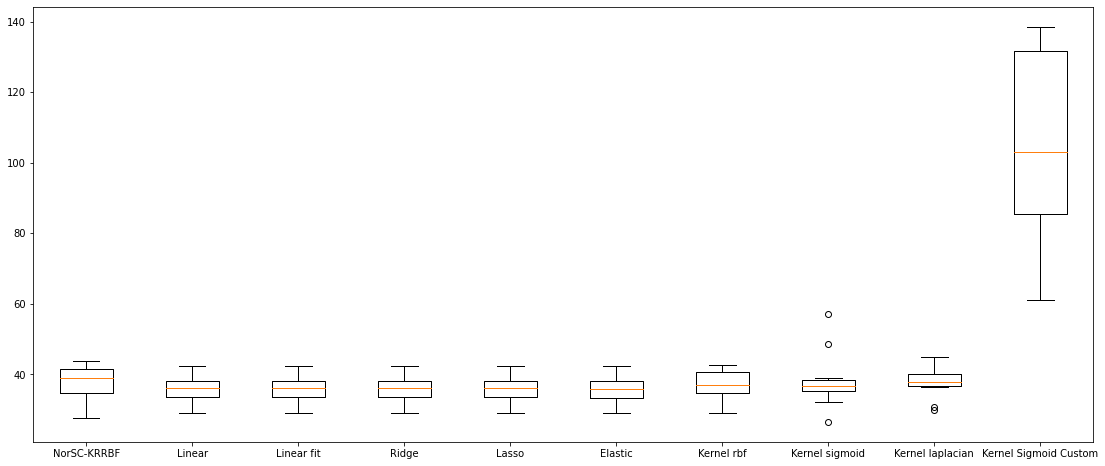

In [25]:
plt.figure(figsize=(19,8))
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()

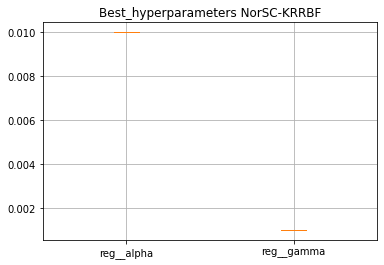

Modes=  [0.01  0.001]
Predicción contagiados covid19  2020-05-10 = [-2.05053944e-118]


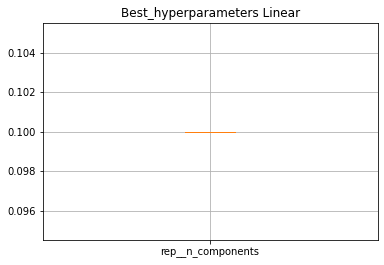

Modes=  [0.1]
Predicción contagiados covid19  2020-05-10 = [11180.03633936]


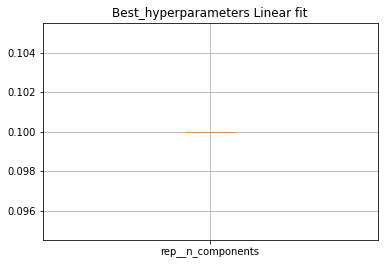

Modes=  [0.1]
Predicción contagiados covid19  2020-05-10 = [11180.03633936]


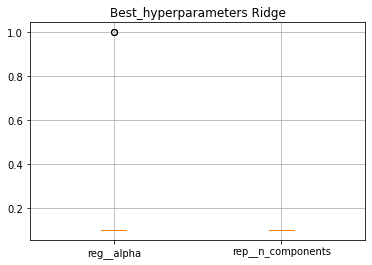

Modes=  [0.1 0.1]
Predicción contagiados covid19  2020-05-10 = [11177.56153098]


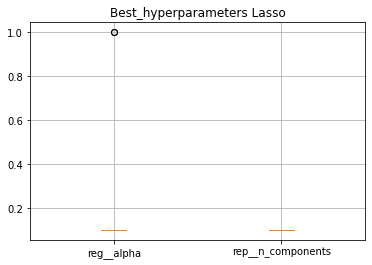

Modes=  [0.1 0.1]
Predicción contagiados covid19  2020-05-10 = 11176.025754948605


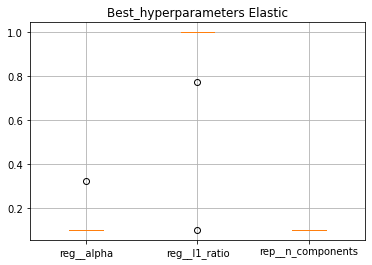

Modes=  [0.1 1.  0.1]
Predicción contagiados covid19  2020-05-10 = 9275.79820791905


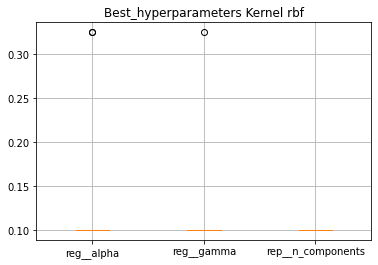

Modes=  [0.1 0.1 0.1]
Predicción contagiados covid19  2020-05-10 = [0.]


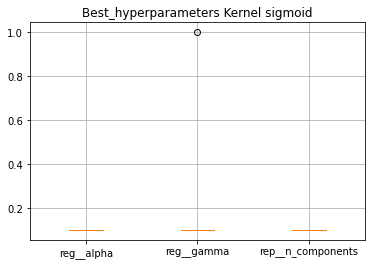

Modes=  [0.1 0.1 0.1]
Predicción contagiados covid19  2020-05-10 = [676.50726912]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


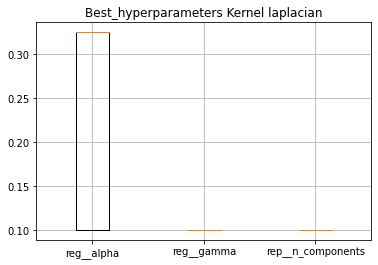

Modes=  [0.325 0.1   0.1  ]
Predicción contagiados covid19  2020-05-10 = [2.37966945e-05]


In [26]:
from scipy.stats import mode
from datetime import date

model_f = np.zeros((10, 1),dtype=object)

for r in range(9):
  nh = len(best_hyperpar[0][r])
  hyperpar_r = np.zeros((Niter,nh)) 
  for i in range(Niter):
    for j in range(nh):
      hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])

# revisar numero entero para realizar casting
  aa = list(best_hyperpar[0][r].keys())
  c = -1
  for i in range(len(aa)):
      if aa[i].find('n_neighbors') > -1:
        c = i

  plt.boxplot(hyperpar_r)
  plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
  plt.title('Best_hyperparameters '+label_model[r])
  plt.grid()
  plt.show()

  mode_hyper = mode(hyperpar_r,axis=0)[0][0]
  print("Modes= ", mode_hyper)

  model_f[r,0] = Pipeline(steps[r])
  paramsf = parameters[r]
  hyperl = list(parameters[r].keys())
  nh = len(hyperl)
  for j in range(nh):
    if j == c: 
      paramsf[hyperl[j]] = int(mode_hyper[j])
    else:
      paramsf[hyperl[j]] = mode_hyper[j] 

  model_f[r,0].set_params(**paramsf)
  model_f[r,0].fit(Xdata,ydata) #entrenar con todos los datos porque no tenemos suficientes > 10000 entrenar xtrain de lo contrario con todo el dataset

  print('Predicción contagiados covid19 ',date.today(),'=',model_f[r,0].predict(serie[len(serie)-w:].reshape(1,-1))[0])

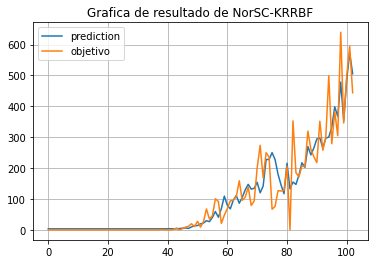

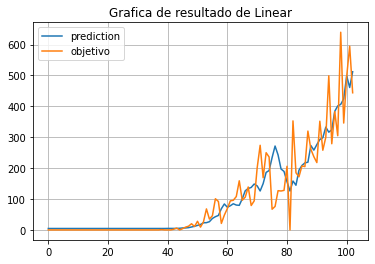

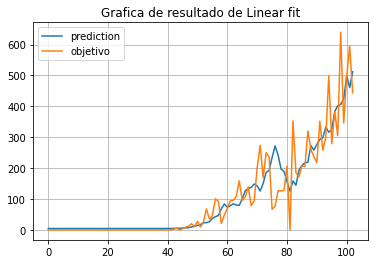

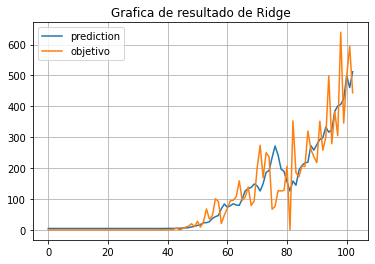

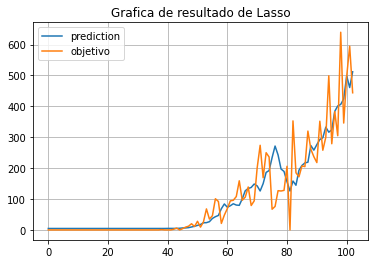

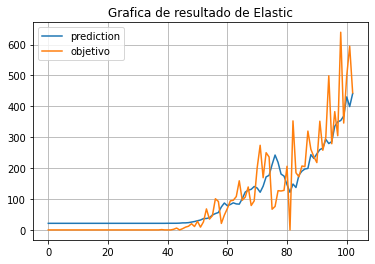

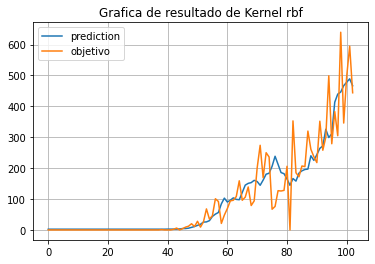

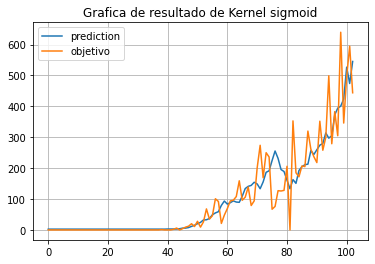

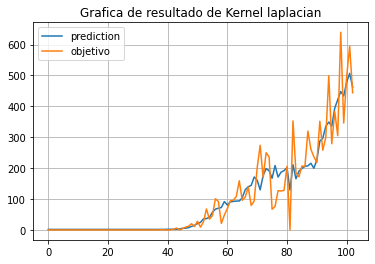

In [28]:
#curva predicción sobre modelo  final
for r in range(9):
  plt.plot(model_f[r,0].predict(Xdata),label='prediction')
  plt.plot(ydata,label='objetivo')
  plt.title('Grafica de resultado de '+label_model[r])
  plt.grid()
  plt.legend()
  plt.show()

###Conclusión
Como era de esperarse los resultados sustentan lo dicho anteriormente, la curva de contagios acumulados resulto ser un problema de regresion muy sencillo, mientras que la curva de contagios por dia, fue un problema mas complejo para los regresores pero aun asi la prediccion es bastante remejante a la curva real. 